### Toggle to see or hide code cells

In [58]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Sample RF example to show A Basic Log Function

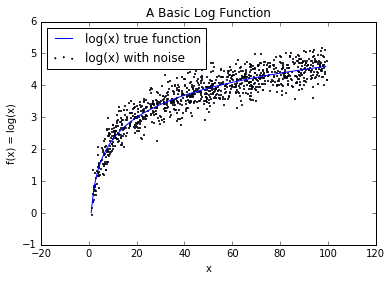

In [55]:
import numpy as np
import pylab as pl
import pandas as pd

x = np.random.uniform(1, 100, 1000)
y = np.log(x) + np.random.normal(0, .3, 1000)

pl.scatter(x, y, s=1, label="log(x) with noise")
pl.plot(np.arange(1, 100), np.log(np.arange(1, 100)), c="b", label="log(x) true function")
pl.xlabel("x")
pl.ylabel("f(x) = log(x)")
pl.legend(loc="best")
pl.title("A Basic Log Function")
pl.show()

In [32]:
# The code was removed by DSX for sharing.

[Row(ACCOUNT_NAME=u'Galaxy Bingo Port Elizabeth', PRODUCT_NAME=u'Ticketing 9.1 SP2', AGE__C=u'50', ANALYST_HOURS__C=u'0', ATTACHED_INCIDENTS__C=u'1', ATTACHED_WORKAROUNDS__C=u'0', AVERAGE_CUSTOMER_COST_HR__C=u'0', AVERAGE_NO_OF_HRS_TO_SOLVE_TKT__C=u'0', COMPLIANCE__C=u'FALSE', COST_PER_HOUR_TO_SOLVE_TKT__C=u'98', CUSTOMER_COST__C=u'0', DEFECT_TYPE__C=u'Defect', IGT_COST__C=u'0', IMPACT__C=u'Medium', KNOWN_ERROR__C=u'FALSE', LIABILITY__C=u'FALSE', MAJOR_PROBLEM__C=u'FALSE', NUMBER_OF_CUSTOMERS_BY_PRODUCT_BUILD__C=u'19', NUMBER_OF_CUSTOMERS_REPORTED__C=u'1', OPEN_TASKS__C=u'0', RCA_COMPLETED__C=u'FALSE', RESOLVED_BY_CR__C=u'FALSE', STATUS__C=u'In Process', STATUS_REASON__C=u'Development', SUB_STATUS_REASON__C=u'Testing', SUBJECT__C=u'jackpot hit payment goes to non deductible credit whereas it s configured as HandPay', TOTAL_COST__C=u'0', URGENCY__C=u'Medium', WORKAROUND_EXISTS__C=u'No'),
 Row(ACCOUNT_NAME=u'Galaxy Bingo Port Elizabeth', PRODUCT_NAME=u'Ticketing 9.1 SP2', AGE__C=u'238', 

In [33]:
dummy = df.unpersist()

In [34]:
### change columns to lower case and cache data
df = df.select(df.columns[:92])
for col in df.columns:
    df = df.withColumnRenamed(col,col.lower())

df = df.cache()
dummy_catcher = df.first()

In [35]:
### filter out accounts with no problem reported
df = df.filter(df.product_name!='')\
       .filter(df.age__c.isNotNull())

In [36]:
## convert a sample of data into Pandas
## Be careful to not convert the entire DF, else it will cost memory resources
df_pd = df.sample(fraction=0.01,withReplacement=False)
df_pd = df.toPandas()

In [38]:
#### select a subset of columns ###
relevant_columns = ['account_name', 'product_name', 'age__c', 'analyst_hours__c', 'attached_incidents__c', 
                    'attached_workarounds__c', 'average_customer_cost_hr__c', 'average_no_of_hrs_to_solve_tkt__c', 
                    'compliance__c', 'cost_per_hour_to_solve_tkt__c', 'customer_cost__c', 'defect_type__c', 
                    'igt_cost__c', 'impact__c', 'known_error__c', 
                    'liability__c', 'major_problem__c', 'number_of_customers_by_product_build__c', 'number_of_customers_reported__c', 
                    'open_tasks__c', 'rca_completed__c', 'resolved_by_cr__c', 'status__c', 
                    'status_reason__c', 'sub_status_reason__c', 'subject__c', 'total_cost__c', 'urgency__c', 'workaround_exists__c']

df = df.select(relevant_columns)
df = df.fillna(0)

In [39]:
# collect categorical columns to be used for later
categorical = ['compliance__c','defect_type__c','impact__c','known_error__c','liability__c',
               'major_problem__c','open_tasks__c','rca_completed__c','resolved_by_cr__c','status__c',
               'status_reason__c','sub_status_reason__c','subject__c','urgency__c','workaround_exists__c']

# collect a set of integer columns
integer_columns = ['analyst_hours__c','attached_incidents__c','attached_workarounds__c','average_customer_cost_hr__c',
                   'average_no_of_hrs_to_solve_tkt__c','cost_per_hour_to_solve_tkt__c','customer_cost__c',
                   'igt_cost__c','number_of_customers_by_product_build__c','number_of_customers_reported__c', 'total_cost__c']

#other columns which uniquely identify rows such as account names and product_ids are not touched
other_cols = set(df.columns).difference(set(integer_columns).union(set(categorical)))

In [40]:
other_cols

{'account_name', 'age__c', 'product_name'}

In [41]:
from pyspark.sql.types import StringType, IntegerType, FloatType
from pyspark.sql.functions import UserDefinedFunction, when

# clean up target column (age__c)
clean_target = UserDefinedFunction(lambda x:0 if x==None else int(x.split(' ')[0]),IntegerType())
df = df.withColumn('age__c',clean_target(df['age__c']))

# cast columns containing number to integertype
for col in integer_columns:
    df = df.withColumn(col,df[col].cast(IntegerType()))
    df = df.withColumn(col,when(df[col].isNull(),0).otherwise(df[col]))
    
# clean up categorical values, make sure that "NULL"s are appropriately converted
for col in categorical:
    df = df.withColumn(col,when(df[col].isNull(),'Unknown_'+col).otherwise(df[col]))

#### Save 'df' 

In [42]:
dataset = df
if 'indexed' in locals():
    del locals()['indexed']

if 'string_encoded' in locals():
        del locals()['string_encoded']

### StringIndex and one-hot encode categorical variables

In [43]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

for cat in categorical:
    stringIndexer = StringIndexer(inputCol=cat,outputCol=cat+'_indexed',handleInvalid='error')
    if 'indexed' in locals():
        indexer = stringIndexer.fit(indexed)
        indexed = indexer.transform(indexed)
    else:
        indexer = stringIndexer.fit(dataset)
        indexed = indexer.transform(dataset)
print ("####### String Indexing done ########")

indexed_columns = [col for col in indexed.columns if '_indexed' in col]
for col in indexed_columns:
    encoder = OneHotEncoder(inputCol=col,outputCol=col+'_encoded')
    if 'string_encoded' in locals():
        string_encoded = encoder.transform(string_encoded)
    else:
        string_encoded = encoder.transform(indexed)
    
print ("####### One-hot encoding done ########")

####### String Indexing done ########
####### One-hot encoding done ########


### Assemble all these columns together to create a feature_set

In [44]:
from pyspark.ml.feature import VectorAssembler

#feature set is a combination of the one-hot encoded columns from above and integer features determined ealier in the NB
string_features = [col for col in string_encoded.columns if '_encoded' in col]
numeric_features = integer_columns
feature_set = string_features+numeric_features

# define a transformer and apply it on the set
numeric_assembler = VectorAssembler(inputCols=numeric_features,outputCol='features_int')
d1 = numeric_assembler.transform(string_encoded)
assembler = VectorAssembler(inputCols = string_features+['features_int'],outputCol='features')
dataset = assembler.transform(d1)

### Transform target into a binary/ multiclass column, select only columns that are needed from 'dataset'

In [45]:
def bucket_target(x):
    if x<=100:
        return 0 
    elif x>100 and x<=200:
        return 1
    else:
        return 2
    
def binary_target(x):
    if x<=150:
        return 0 
    else:
        return 1 
    
compute_target_multi = UserDefinedFunction(lambda x:bucket_target(x), IntegerType())
compute_target_binary = UserDefinedFunction(lambda x:binary_target(x), IntegerType())

model_data = dataset.select('age__c','features','product_name','account_name')
model_data = model_data.filter(model_data.age__c>=0)
model_data_multiclass = model_data.withColumn('age__c',compute_target_multi(model_data['age__c']))
model_data_binary = model_data.withColumn('age__c',compute_target_binary(model_data['age__c']))

In [46]:
### register DFs as temp tables
model_data_multiclass.registerTempTable('igt_data')
model_data_binary.registerTempTable('igt_binary')

In [47]:
query = """
select age__c, 
       count(1)
from igt_data
group by 1
"""
spark.sql(query).toPandas()

,age__c,count(1)
0,1,307
1,2,1100
2,0,288


In [48]:
query = """
select age__c, 
       count(1)
from igt_binary
group by 1
"""
spark.sql(query).toPandas()

,age__c,count(1)
0,1,1266
1,0,429


### Split into test and train 

In [49]:
train_binary, test_binary = model_data_binary.randomSplit([0.7,0.3])
train_multi, test_multi = model_data_multiclass.randomSplit([0.7,0.3])

### Define evaluators for binary classification

In [50]:
#### Classification metrics ####
def calc_metrics(results,label_col,prediction_col):
    metrics = {}
    metrics['tp_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fn_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==1)).count()
    metrics['tn_0'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fp_0'] = results.filter((results[label_col]==1)&(results[prediction_col]==0)).count()
    
    metrics['tp_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fn_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==0)).count()
    metrics['tn_1'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fp_1'] = results.filter((results[label_col]==0)&(results[prediction_col]==1)).count()
    
    return metrics
        
### calc precision & recall ###
def precision_recall(results,label_col,prediction_col):
    items = calc_metrics(results,label_col,prediction_col)
    rows = []
    
    row = {'class':0,'precision':items['tp_0']/float((items['tp_0']+items['fp_0'])+1),'recall':items['tp_0']/float((items['tp_0']+items['fn_0'])+1)}
    rows.append(row)
    row = {'class':1,'precision':items['tp_1']/float((items['tp_1']+items['fp_1'])+1),'recall':items['tp_1']/float((items['tp_1']+items['fn_1'])+1)}
    rows.append(row)
    
    return rows

### Define evaluators for multi-class classification

In [51]:
#### Classification metrics multi ####
def calc_metrics_multi(results,label_col,prediction_col):
    metrics = {}
    metrics['tp_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fn_0'] = results.filter((results[label_col]==0)&(results[prediction_col]!=0)).count()
    metrics['tn_0'] = results.filter((results[label_col]!=0)&(results[prediction_col]!=0)).count()
    metrics['fp_0'] = results.filter((results[label_col]!=0)&(results[prediction_col]==0)).count()
    
    metrics['tp_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fn_1'] = results.filter((results[label_col]==1)&(results[prediction_col]!=1)).count()
    metrics['tn_1'] = results.filter((results[label_col]!=1)&(results[prediction_col]!=1)).count()
    metrics['fp_1'] = results.filter((results[label_col]!=1)&(results[prediction_col]==1)).count()
    
    metrics['tp_2'] = results.filter((results[label_col]==2)&(results[prediction_col]==2)).count()
    metrics['fn_2'] = results.filter((results[label_col]==2)&(results[prediction_col]!=2)).count()
    metrics['tn_2'] = results.filter((results[label_col]!=2)&(results[prediction_col]!=2)).count()
    metrics['fp_2'] = results.filter((results[label_col]!=2)&(results[prediction_col]==2)).count()
    
    metrics['tp_3'] = results.filter((results[label_col]==3)&(results[prediction_col]==3)).count()
    metrics['fn_3'] = results.filter((results[label_col]==3)&(results[prediction_col]!=3)).count()
    metrics['tn_3'] = results.filter((results[label_col]!=3)&(results[prediction_col]!=3)).count()
    metrics['fp_3'] = results.filter((results[label_col]!=3)&(results[prediction_col]==3)).count()
    
    
    return metrics
        
### calc precision & recall ###
def precision_recall_multi(results,label_col,prediction_col):
    items = calc_metrics_multi(results,label_col,prediction_col)
    rows = []
    
    row = {'class':0, 'precision':items['tp_0']/float((items['tp_0']+items['fp_0'])+1), 
                       'recall':items['tp_0']/float((items['tp_0']+items['fn_0'])+1)}
    rows.append(row)
     
    row = {'class':1, 'precision':items['tp_1']/float((items['tp_1']+items['fp_1'])+1),
                      'recall':items['tp_1']/float((items['tp_1']+items['fn_1'])+1)}
    rows.append(row)
    
    row = {'class':2, 'precision':items['tp_2']/float((items['tp_2']+items['fp_2'])+1),
                      'recall':items['tp_2']/float((items['tp_2']+items['fn_2'])+1)}
    rows.append(row)
    
#     row = {'class':3, 'precision':items['tp_3']/float((items['tp_3']+items['fp_3'])+1),
#                        'recall':items['tp_3']/float((items['tp_3']+items['fn_3'])+1)}
#     rows.append(row)
    return pd.DataFrame(rows)

## Binary classification

### LR Model ####

In [56]:
# define LR model and get predictions
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='age__c',featuresCol='features',regParam=0.5,maxIter=1000)
lr_model = lr.fit(train_binary)

predictions_lr = lr_model.transform(test_binary)
result = pd.DataFrame(precision_recall(predictions_lr,'age__c','prediction'))
result

,class,precision,recall
0,0,0.500000,0.024194
1,1,0.764591,0.992424


### GBT

In [57]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="age__c", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_binary)
results_gbt = gbt_model.transform(test_binary)
results = pd.DataFrame(precision_recall(results_gbt,'age__c','prediction'))
results

,class,precision,recall
0,0,0.628049,0.830645
1,1,0.941011,0.845960


## MultiClass classification

### Logistic regression

In [60]:
#### Logistic One-vs-all
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True,featuresCol='features',labelCol='age__c')

# instantiate and train the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr, featuresCol='features',labelCol='age__c')
ovrModel = ovr.fit(train_multi)

# score the model on test data.
predictions = ovrModel.transform(test_multi)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='age__c')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))
print ("Cumulative F1-Score : %.2d"% f1)

results = pd.DataFrame(precision_recall_multi(predictions,'age__c','prediction'))
results

Test Error = 0.285178
Cumulative F1-Score : 00


,class,precision,recall
0,0,0.551020,0.313953
1,1,0.535211,0.387755
2,2,0.799486,0.956923


### Cross validated LR model (compute intensive)

In [380]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# paramGrid = ParamGridBuilder() \
#     .addGrid(lr.regParam, [0.1, 0.01,0.5]) \
#     .build()
    
# crossval = CrossValidator(estimator=ovr,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=MulticlassClassificationEvaluator(metricName="f1",labelCol='age__c'),
#                           numFolds=5)  

# # Run cross-validation, and choose the best set of parameters.
# cvModel = crossval.fit(train_multi)
# prediction = cvModel.transform(test_multi)
# prediction

### Decision Tree model

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
dt = DecisionTreeClassifier(labelCol='indexed',featuresCol='features',maxDepth=30)
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=dt, featuresCol='features',labelCol='age__c')

# split dataset and train the multiclass model.
ovrModel = ovr.fit(train_multi)

# score the model on test data.
predictions = ovrModel.transform(test_multi)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='age__c')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))


result = pd.DataFrame(precision_recall_multi(predictions,'age__c','prediction'))
result

Test Error = 0.287626


,class,precision,recall
0,0,0.421875,0.313953
1,1,0.536585,0.448980
2,2,0.820937,0.916923


## Alternate workflow  (include product_ids) ####


In [62]:
### add product ids to the set of categorical columns ###
categorical = categorical + ['product_name']
dataset_products = df

In [63]:
if 'indexed' in locals():
    del locals()['indexed']
if 'string_encoded' in locals():
        del locals()['string_encoded']
        
for cat in categorical:
    stringIndexer = StringIndexer(inputCol=cat,outputCol=cat+'_indexed',handleInvalid='error')
    if 'indexed' in locals():
        indexer = stringIndexer.fit(indexed)
        indexed = indexer.transform(indexed)
    else:
        indexer = stringIndexer.fit(dataset_products)
        indexed = indexer.transform(dataset_products)
print ("####### String Indexing done ########")

indexed_columns = [col for col in indexed.columns if '_indexed' in col]
for col in indexed_columns:
    encoder = OneHotEncoder(inputCol=col,outputCol=col+'_encoded')
    if 'string_encoded' in locals():
        string_encoded = encoder.transform(string_encoded)
    else:
        string_encoded = encoder.transform(indexed)
    
print ("####### One-hot encoding done ########")

####### String Indexing done ########
####### One-hot encoding done ########


In [64]:
#feature set is a combination of the one-hot encoded columns from above and integer features determined ealier in the NB
string_features = [col for col in string_encoded.columns if '_encoded' in col]
numeric_features = integer_columns
feature_set = string_features+numeric_features

# define a transformer and apply it on the set
numeric_assembler = VectorAssembler(inputCols=numeric_features,outputCol='features_int')
d1 = numeric_assembler.transform(string_encoded)
assembler = VectorAssembler(inputCols = string_features+['features_int'],outputCol='features')
dataset_products = assembler.transform(d1)

In [66]:
def bucket_target(x):
    if x<=100:
        return 0 
    elif x>100 and x<=200:
        return 1
    else:
        return 2
    
compute_target = UserDefinedFunction(lambda x:bucket_target(x), IntegerType())

model_data_products = dataset_products.select('age__c','features','product_name','account_name')
model_data_products = model_data_products.filter(model_data_products.age__c>=0)
model_data_products = model_data_products.withColumn('age__c',compute_target(model_data_products['age__c']))

In [67]:
model_data_products.registerTempTable('igt_data_products')

In [68]:
query = """
select age__c label, 
       count(1)
from igt_data_products
group by 1
"""
spark.sql(query).toPandas()

,label,count(1)
0,1,307
1,2,1100
2,0,288


In [69]:
train_multi_products, test_multi_products = model_data_products.randomSplit([0.7,0.3])

### One-vs-all classification

In [70]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
lr = LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True,featuresCol='features',labelCol='age__c')

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr, featuresCol='features',labelCol='age__c')

# split dataset and train the multiclass model.
ovrModel = ovr.fit(train_multi_products)

# score the model on test data.
predictions = ovrModel.transform(test_multi_products)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='age__c')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))

results = pd.DataFrame(precision_recall_multi(predictions,'age__c','prediction'))
results

Test Error = 0.379355


,class,precision,recall
0,0,0.433333,0.136842
1,1,0.405063,0.347826
2,2,0.738544,0.935154


### Decision Tree

In [71]:
from pyspark.ml.classification import DecisionTreeClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
dt = DecisionTreeClassifier(labelCol='indexed',featuresCol='features',maxDepth=30)
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=dt, featuresCol='features',labelCol='age__c')

# split dataset and train the multiclass model.
ovrModel = ovr.fit(train_multi_products)

# score the model on test data.
predictions = ovrModel.transform(test_multi_products)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='age__c')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))

result = pd.DataFrame(precision_recall_multi(predictions,'age__c','prediction'))
result

Test Error = 0.261854


,class,precision,recall
0,0,0.504950,0.536842
1,1,0.512195,0.456522
2,2,0.875421,0.887372
